In [2]:

import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageOps
import random


In [3]:

def augment_image(image):
    """
    Apply random augmentations to an image using Pillow.
    """
    # Random rotation
    if random.random() > 0.5:
        angle = random.uniform(-30, 30)  # Rotate between -30 and 30 degrees
        image = image.rotate(angle, expand=True)

    # Random horizontal flip
    if random.random() > 0.5:
        image = ImageOps.mirror(image)

    # Random brightness adjustment
    if random.random() > 0.5:
        enhancer = ImageEnhance.Brightness(image)
        factor = random.uniform(0.8, 1.2)  # Brightness factor
        image = enhancer.enhance(factor)

    # Random zoom (crop and resize back)
    if random.random() > 0.5:
        width, height = image.size
        zoom_factor = random.uniform(0.8, 1.2)  # Zoom in/out factor
        new_width = int(width * zoom_factor)
        new_height = int(height * zoom_factor)
        image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)  # Use Resampling.LANCZOS
        if zoom_factor > 1:
            # Crop to original size
            left = (new_width - width) // 2
            top = (new_height - height) // 2
            image = image.crop((left, top, left + width, top + height))
        else:
            # Pad to original size
            image = ImageOps.pad(image, (width, height), color=(0, 0, 0))

    return image


In [4]:

def preprocess_and_augment_with_pillow(input_dir, output_dir, img_size=(128, 128), augmentations=2):
    """
    Preprocesses and augments images using OpenCV and Pillow.
    
    Args:
        input_dir (str): Path to the input dataset directory.
        output_dir (str): Path to the output directory for preprocessed and augmented images.
        img_size (tuple): Target size for resizing the images (width, height).
        augmentations (int): Number of augmented images to generate per input image.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate through each person's folder in the dataset
    for person_name in os.listdir(input_dir):
        person_folder = os.path.join(input_dir, person_name)
        output_person_folder = os.path.join(output_dir, person_name)

        if not os.path.isdir(person_folder):
            continue  # Skip files, only process directories

        # Create corresponding output directory for each person if it doesn't exist
        if not os.path.exists(output_person_folder):
            os.makedirs(output_person_folder)

        # Process each image in the person's folder
        for img_name in os.listdir(person_folder):
            img_path = os.path.join(person_folder, img_name)
            
            # Read the image using OpenCV
            image = cv2.imread(img_path)
            if image is None:
                print(f"Warning: Could not read image {img_path}")
                continue

            # Step 1: Resize the image
            image_resized = cv2.resize(image, img_size)

            # Step 2: Apply Bilateral Filter for noise reduction while preserving edges
            image_bilateral = cv2.bilateralFilter(image_resized, d=9, sigmaColor=75, sigmaSpace=75)

            # Step 3: Convert to grayscale for thresholding
            gray = cv2.cvtColor(image_bilateral, cv2.COLOR_BGR2GRAY)

            # Step 4: Apply simple thresholding for background removal
            _, thresholded = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)

            # Apply the threshold mask to the original image
            foreground = cv2.bitwise_and(image_bilateral, image_bilateral, mask=thresholded)

            # Save the preprocessed image
            preprocessed_path = os.path.join(output_person_folder, f"processed_{img_name}")
            cv2.imwrite(preprocessed_path, foreground)
            print(f"Preprocessed and saved: {preprocessed_path}")

            # Convert to Pillow Image for augmentation
            pil_image = Image.fromarray(cv2.cvtColor(foreground, cv2.COLOR_BGR2RGB))

            # Step 5: Apply data augmentation with Pillow
            for i in range(augmentations):
                augmented_image = augment_image(pil_image)  # Apply random augmentations
                aug_img_path = os.path.join(output_person_folder, f"aug_{i}_{img_name}")
                augmented_image.save(aug_img_path)
                print(f"Augmented and saved: {aug_img_path}")


In [5]:

# Define input and output directories
input_directory = "Indian_actors_faces"          # Replace with the path to your dataset folder
output_directory = "augmented_dataset"           # Where augmented images will be saved

# Call the preprocessing and augmentation function
preprocess_and_augment_with_pillow(input_directory, output_directory, augmentations=2)

Preprocessed and saved: augmented_dataset\pankaj_kapur\processed_090288c011.jpg
Augmented and saved: augmented_dataset\pankaj_kapur\aug_0_090288c011.jpg
Augmented and saved: augmented_dataset\pankaj_kapur\aug_1_090288c011.jpg
Preprocessed and saved: augmented_dataset\pankaj_kapur\processed_0b6f381312.jpg
Augmented and saved: augmented_dataset\pankaj_kapur\aug_0_0b6f381312.jpg
Augmented and saved: augmented_dataset\pankaj_kapur\aug_1_0b6f381312.jpg
Preprocessed and saved: augmented_dataset\pankaj_kapur\processed_12fa72e5b3.jpg
Augmented and saved: augmented_dataset\pankaj_kapur\aug_0_12fa72e5b3.jpg
Augmented and saved: augmented_dataset\pankaj_kapur\aug_1_12fa72e5b3.jpg
Preprocessed and saved: augmented_dataset\pankaj_kapur\processed_1ab9ede00c.jpg
Augmented and saved: augmented_dataset\pankaj_kapur\aug_0_1ab9ede00c.jpg
Augmented and saved: augmented_dataset\pankaj_kapur\aug_1_1ab9ede00c.jpg
Preprocessed and saved: augmented_dataset\pankaj_kapur\processed_1c74bd375f.jpg
Augmented and sa

In [6]:

import os
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:

def load_dataset(dataset_dir, img_size=(128, 128)):
    """
    Load images and labels from the specified dataset directory.

    Args:
        dataset_dir (str): Path to dataset directory.
        img_size (tuple): Target size for resizing images.

    Returns:
        tuple: Tuple containing image data (X), labels (y), and LabelEncoder instance.
    """
    X, y = [], []
    label_names = []

    for person_name in os.listdir(dataset_dir):
        person_folder = os.path.join(dataset_dir, person_name)
        if not os.path.isdir(person_folder):
            continue

        label_names.append(person_name)
        for img_name in os.listdir(person_folder):
            img_path = os.path.join(person_folder, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(person_name)

    X = np.array(X, dtype='float32') / 255.0  # Normalize images
    y = np.array(y)

    # Encode labels to integers
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    return X, y, label_encoder


In [8]:

def build_model(input_shape, num_classes, learning_rate=0.001):
    """
    Build and compile a CNN model.

    Args:
        input_shape (tuple): Shape of the input images.
        num_classes (int): Number of output classes.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        model: Compiled CNN model.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [9]:

def plot_training_history(history):
    """
    Plot training and validation accuracy and loss.

    Args:
        history: Training history object from Keras model.
    """
    # Accuracy Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=range(1, len(history.history['accuracy']) + 1), y=history.history['accuracy'], label='Training Accuracy', color='blue')
    sns.lineplot(x=range(1, len(history.history['val_accuracy']) + 1), y=history.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Loss Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], label='Training Loss', color='blue')
    sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], label='Validation Loss', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


C:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 15s 411ms/step - accuracy: 0.1075 - loss: 2.8040 - val_accuracy: 0.2253 - val_loss: 2.3861
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 393ms/step - accuracy: 0.1634 - loss: 2.3478 - val_accuracy: 0.3652 - val_loss: 2.1489
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 375ms/step - accuracy: 0.3527 - loss: 1.9497 - val_accuracy: 0.4676 - val_loss: 1.7142
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 355ms/step - accuracy: 0.5784 - loss: 1.3290 - val_accuracy: 0.5529 - val_loss: 1.5034
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step - accuracy: 0.6656 - loss: 1.0194 - val_accuracy: 0.5870 - val_loss: 1.3395
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 336ms/step - accuracy: 0.7575 - loss: 0.7282 - val_accuracy: 0.6109 - val_loss: 1.3254
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.8469 - loss: 0.4898 - val_accuracy: 0.6041 - val_loss: 1.4196
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step - accuracy: 0.8677 - loss: 0.4146 - val_accu

Final Training Accuracy: 90.35%
Final Validation Accuracy: 61.77%
Model saved at face_recognition_model.h5


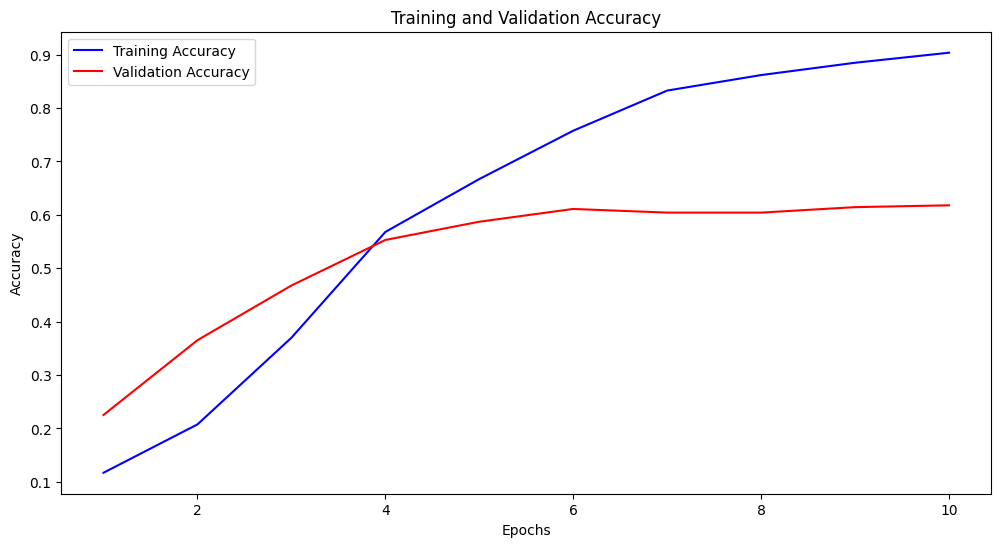

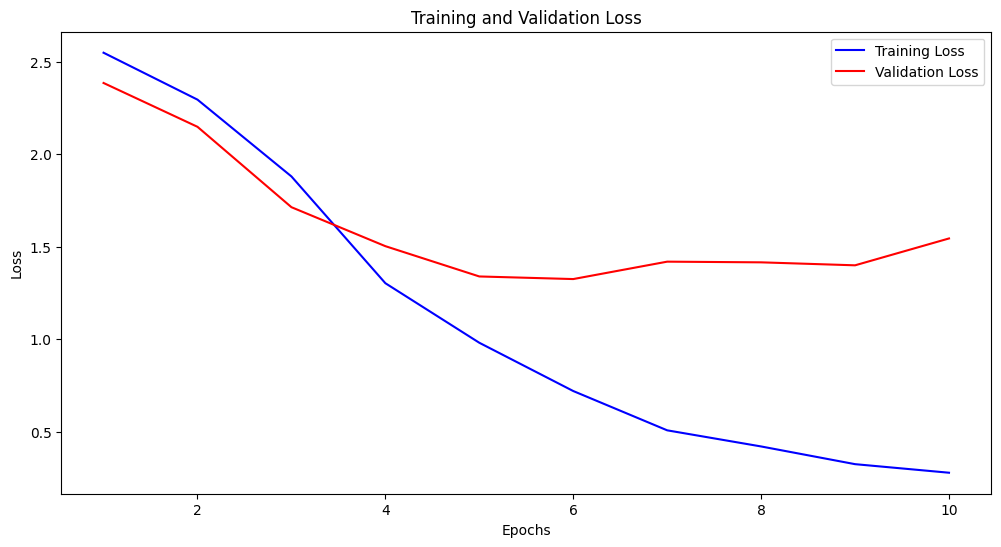

In [10]:

def train_model(dataset_dir, output_model_path, img_size=(128, 128), learning_rate=0.001):
    """
    Train and save a face recognition model.

    Args:
        dataset_dir (str): Path to dataset directory.
        output_model_path (str): Path to save the trained model.
        img_size (tuple): Target size for resizing images.
        learning_rate (float): Learning rate for the optimizer.
    """
    # Load dataset
    X, y, label_encoder = load_dataset(dataset_dir, img_size)
    num_classes = len(np.unique(y))

    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build and train the model
    model = build_model(input_shape=(img_size[0], img_size[1], 3), num_classes=num_classes, learning_rate=learning_rate)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=38)

    # Extract final accuracy values
    final_train_accuracy = history.history['accuracy'][-1] * 100  # Convert to percentage
    final_val_accuracy = history.history['val_accuracy'][-1] * 100  # Convert to percentage

    # Print training and validation accuracy as percentages
    print(f"Final Training Accuracy: {final_train_accuracy:.2f}%")
    print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")

    # Save the model and label encoder
    model.save(output_model_path)
    np.save(output_model_path + "_labels.npy", label_encoder.classes_)
    print(f"Model saved at {output_model_path}")

    # Plot training history
    plot_training_history(history)

# Example Usage
dataset_directory = "augmented_dataset"  # Path to dataset
output_model_file = "face_recognition_model.h5"  # Path to save model

train_model(dataset_directory, output_model_file)